In [ ]:
import xgboost as xgb
import lightgbm as lgbm
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import pandas as pd
import numpy as np
from geopy.distance import geodesic 
import math
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
num_folds = 10
n_iter = 1000
n_estimators = 100
scoring = 'r2'

models = []
models.append(('R', Ridge()))
models.append(('L', Lasso()))
models.append(('ELN', ElasticNet()))
models.append(('LARS', LarsCV()))
models.append(('BR', BayesianRidge(n_iter=n_iter)))
models.append(('KNR', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('LSVR', LinearSVR()))
models.append(('SVR', SVR()))
models.append(('ABR', AdaBoostRegressor(n_estimators=n_estimators)))
models.append(('BR', BaggingRegressor(n_estimators=n_estimators)))
models.append(('ETR', ExtraTreesRegressor(n_estimators=n_estimators)))
models.append(('GBR', GradientBoostingRegressor(n_estimators=n_estimators)))
models.append(('RFR', RandomForestRegressor(n_estimators=n_estimators)))
models.append(('XGB', xgb.XGBRegressor(n_estimators=n_estimators)))
models.append(('LGBM', lgbm.LGBMRegressor(n_estimators=n_estimators)))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2378 entries, 0 to 2377
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2378 non-null   int64  
 1   total_area     2378 non-null   float64
 2   living_area    2378 non-null   float64
 3   kitchen_area   2378 non-null   float64
 4   floor_number   2378 non-null   float64
 5   total_floors   2378 non-null   float64
 6   year           2378 non-null   float64
 7   material_type  2378 non-null   int64  
 8   lng            2378 non-null   float64
 9   lat            2378 non-null   float64
 10  underground    2378 non-null   int64  
 11  distance       2378 non-null   float64
 12  azimuth        2378 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 260.1 KB


{'boxes': [<matplotlib.lines.Line2D at 0x7f09cf3bfa90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f09cf4d7fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f09cf7a1d50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f09cf7a1310>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f09cf7b2450>,
  <matplotlib.lines.Line2D at 0x7f09cf7b2e90>]}

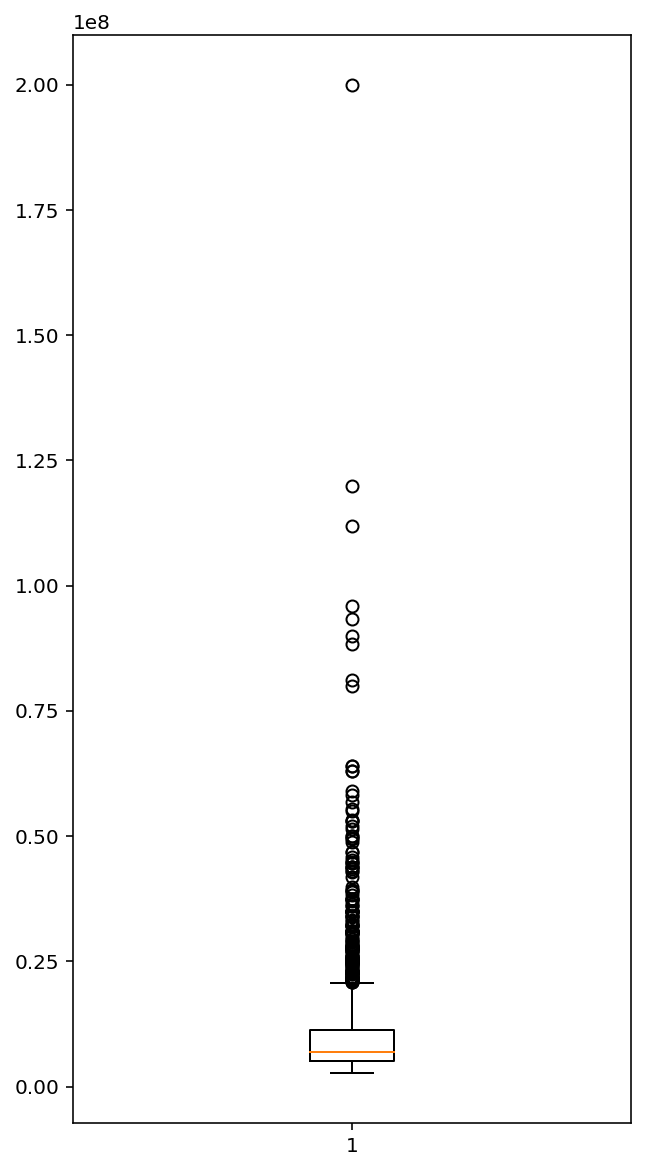

In [156]:
df = pd.read_csv('https://raw.githubusercontent.com/MaltsevaNata/FlatPrices_Vahta/master/prediction_model/flat_spb_complete.csv')

def get_azimuth(lat, lng):
 
    rad = 6372795

    llat1 = city_center_coordinates[0]
    llong1 = city_center_coordinates[1]
    llat2 = lat
    llong2 = lng

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)

    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 2)

from geopy.distance import geodesic
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder

city_center_coordinates = [59.9375, 30.3086]
df['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).meters, df['lat'], df['lng']))
df['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), df['lat'], df['lng']))     

df = df.loc[(df['distance'] < 40000)] 
df['distance'] = df['distance'].round(0)
df['azimuth'] = df['azimuth'].round(0)

df.info()

fig = plt.figure(figsize=(5,10))
plt.boxplot(df['price'])


In [157]:
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = df[(df > (third_quartile + 3 * IQR)) | (df < (first_quartile - 0.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)

# Deleting some lines
outliers = outliers.head(100)
df.drop(outliers.index, inplace=True)

categorical_columns = df.columns[df.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    df[column] = labelencoder.fit_transform(df[column])
    print(dict(enumerate(labelencoder.classes_)))

df = df[df.price < 200000000]


df.info()
min(df.price)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2377
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2278 non-null   int64  
 1   total_area     2278 non-null   float64
 2   living_area    2278 non-null   float64
 3   kitchen_area   2278 non-null   float64
 4   floor_number   2278 non-null   float64
 5   total_floors   2278 non-null   float64
 6   year           2278 non-null   float64
 7   material_type  2278 non-null   int64  
 8   lng            2278 non-null   float64
 9   lat            2278 non-null   float64
 10  underground    2278 non-null   int64  
 11  distance       2278 non-null   float64
 12  azimuth        2278 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 249.2 KB


2664641

In [158]:
max(df.price)

81092550

In [159]:
y = df['price']
features = [
            'total_area',
            'living_area',
            'kitchen_area',
            'floor_number',
            'total_floors',
            'year',
            'material_type',
            'underground',
            'distance',
            'azimuth'
           ]

X = df[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.15)

print(min(df['price']))

2664641


In [160]:
scores = []
names = []
results = []
predictions = []
msg_row = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model,train_X, train_y, cv=kfold, scoring=scoring)
    names.append(name)
    results.append(cv_results)
    m_fit = model.fit(train_X, train_y)
    m_predict = model.predict(val_X)
    predictions.append(m_predict)
    m_score = model.score(val_X, val_y)
    scores.append(m_score)
    msg = "%s: train = %.3f (%.3f) / test = %.3f" % (name, cv_results.mean(), cv_results.std(), m_score)
    msg_row.append(msg)
    print(msg)

R: train = 0.766 (0.071) / test = 0.699
L: train = 0.766 (0.071) / test = 0.699
ELN: train = 0.766 (0.071) / test = 0.699
LARS: train = 0.763 (0.070) / test = 0.699
BR: train = 0.766 (0.071) / test = 0.699
KNR: train = 0.583 (0.114) / test = 0.670
DTR: train = 0.680 (0.099) / test = 0.736
LSVR: train = 0.281 (0.045) / test = 0.241
SVR: train = -0.107 (0.028) / test = -0.078
ABR: train = 0.504 (0.137) / test = 0.582
BR: train = 0.843 (0.064) / test = 0.849
ETR: train = 0.859 (0.058) / test = 0.856
GBR: train = 0.832 (0.066) / test = 0.860
RFR: train = 0.842 (0.066) / test = 0.842
[20:19:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:37] WARNING: /workspace/sr

Best result: BR, ETR, RFR, LGBM

Improving learning parameters for this methods:

In [161]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Вычисляет медианную абсолютную процентную ошибку
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

#Печатает рассчитанные значения коэффициента детерминации, средней и медианной абсолютных ошибок
def print_metrics(prediction, val_y):
    val_mae = mean_absolute_error(val_y, prediction)
    median_AE = median_absolute_error(val_y, prediction)
    r2 = r2_score(val_y, prediction)

    print('')
    print('R\u00b2: {:.2}'.format(r2))
    print('')
    print('Mean absolute error: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Median absolute error: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))

In [162]:
rf_model = RandomForestRegressor(n_estimators=100, 
                                 n_jobs=-1,  
                                 bootstrap=True,
                                 criterion='mse',
                                 max_features=3,
                                 random_state=7,
                                 max_depth=55,
                                 min_samples_split=2
                                 )

rf_model.fit(train_X, train_y)

rf_prediction = rf_model.predict(val_X).round(0)

print_metrics(rf_prediction, val_y)


R²: 0.86

Mean absolute error: 8.48 %
Median absolute error: 2.48 %


In [163]:
br_model = BaggingRegressor(n_estimators=2000,
                            max_samples=0.6,
                            max_features=1.0)

br_model.fit(train_X, train_y)

br_prediction = br_model.predict(val_X).round(0)

print_metrics(br_prediction, val_y)




R²: 0.84

Mean absolute error: 9.45 %
Median absolute error: 3.88 %


In [ ]:
type(br_model)

sklearn.ensemble._bagging.BaggingRegressor

In [164]:
etr_model = ExtraTreesRegressor(n_estimators=1000,
                                max_depth=50,
                                min_samples_split=5,
                                max_samples=0.7)
etr_model.fit(train_X, train_y)

etr_prediction = etr_model.predict(val_X).round(0)

print_metrics(etr_prediction, val_y)


R²: 0.85

Mean absolute error: 8.04 %
Median absolute error: 1.72 %


In [165]:
lgbm_model = lgbm.LGBMRegressor(boosting_type='dart',
                                     num_leaves=50,
                                     max_depth=-1,
                                     n_estimators=100)
lgbm_model.fit(train_X, train_y)

lgbm_prediction = lgbm_model.predict(val_X).round(0)

print_metrics(lgbm_prediction, val_y)


R²: 0.81

Mean absolute error: 13.2 %
Median absolute error: 10.9 %


In [166]:
from sklearn.externals import joblib

In [168]:
with open('/content/gdrive/My Drive/saintp_model.pkl', 'wb') as f:
  joblib.dump(etr_model, f)

# Load from file
with open('/content/gdrive/My Drive/saintp_model.pkl', 'rb') as f:
  joblib_model = joblib.load(f)

# Calculate the accuracy and predictions
score = joblib_model.score(val_X, val_y)
print("Test score: {0:.2f} %".format(100 * score))


Test score: 85.42 %
